In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 16.3 MB/s 


In [ ]:
!pip install segmentation-models==0.1.2

     |████████████████████████████████| 45 kB 2.7 MB/s 


# Import libraries

In [ ]:
#@title Libraries
%pylab inline
import imutils
import pandas as pd
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import matplotlib.image as mpimg
from PIL import Image as im
# import segmentation_models_pytorch as smp
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage, misc
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from scipy.misc import face
from scipy.signal.signaltools import wiener
import sys
import numpy as np
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
from skimage import feature, io, color, filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import sobel
from skimage.draw import polygon
from skimage import exposure
from skimage.transform import resize
from PIL import Image
import scipy.ndimage as snd
#from meta-pseudo-labels.
from random import seed
from random import random
from tensorflow.keras.layers.experimental import preprocessing 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Viewer requires Qt


# Mount file syste,

In [ ]:
#@title Driver mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [ ]:
dfS = pd.read_csv('/content/drive/MyDrive/Thesis/pos/Sdata.csv')

In [ ]:
label = cv2.imread(dfS['mask'][0])

In [ ]:
for i in range(0, len(dfS)):
  image = cv2.imread(dfS['mask'][i])
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(dfS['mask'][i], gray_image)

KeyboardInterrupt: ignored

# EfficientUnet

## Efficientnet

In [ ]:
#@title Efficientnet
from keras import models, layers
# import sys  
# sys.path.insert(0, '/content/drive/MyDrive/Thesis/MPL/EfficientUnet/efficientunet')
from tensorflow.keras.utils import get_file
# from utils import *

__all__ = ['get_model_by_name', 'get_efficientnet_b0_encoder', 'get_efficientnet_b1_encoder',
           'get_efficientnet_b2_encoder', 'get_efficientnet_b3_encoder', 'get_efficientnet_b4_encoder',
           'get_efficientnet_b5_encoder', 'get_efficientnet_b6_encoder', 'get_efficientnet_b7_encoder']


def _efficientnet(input_shape, blocks_args_list, global_params):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon

    # Stem part
    model_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(
        filters=round_filters(32, global_params),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='stem_conv2d'
    )(model_input)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='stem_batch_norm'
    )(x)

    x = Swish(name='stem_swish')(x)

    # Blocks part
    idx = 0
    drop_rate = global_params.drop_connect_rate
    n_blocks = sum([blocks_args.num_repeat for blocks_args in blocks_args_list])
    drop_rate_dx = drop_rate / n_blocks

    for blocks_args in blocks_args_list:
        assert blocks_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        blocks_args = blocks_args._replace(
            input_filters=round_filters(blocks_args.input_filters, global_params),
            output_filters=round_filters(blocks_args.output_filters, global_params),
            num_repeat=round_repeats(blocks_args.num_repeat, global_params)
        )

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
        idx += 1

        if blocks_args.num_repeat > 1:
            blocks_args = blocks_args._replace(input_filters=blocks_args.output_filters, strides=[1, 1])

        for _ in range(blocks_args.num_repeat - 1):
            x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
            idx += 1

    # Head part
    x = layers.Conv2D(
        filters=round_filters(1280, global_params),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='head_conv2d'
    )(x)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='head_batch_norm'
    )(x)

    x = Swish(name='head_swish')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

    if global_params.dropout_rate > 0:
        x = layers.Dropout(global_params.dropout_rate)(x)

    x = layers.Dense(
        global_params.num_classes,
        kernel_initializer=dense_kernel_initializer,
        activation='softmax',
        name='head_dense'
    )(x)

    model = models.Model(model_input, x)

    return model


def get_model_by_name(model_name, input_shape, classes=3, pretrained=False):
    """Get an EfficientNet model by its name.
    """
    blocks_args, global_params = get_efficientnet_params(model_name, override_params={'num_classes': classes})
    model = _efficientnet(input_shape, blocks_args, global_params)

    try:
        if pretrained:
            weights = IMAGENET_WEIGHTS[model_name]
            weights_path = get_file(
                weights['name'],
                weights['url'],
                cache_subdir='models',
                md5_hash=weights['md5'],
            )
            model.load_weights(weights_path)
    except KeyError as e:
        print("NOTE: Currently model {} doesn't have pretrained weights, therefore a model with randomly initialized"
              " weights is returned.".format(e))

    return model


def _get_efficientnet_encoder(model_name, input_shape, pretrained=False):
    model = get_model_by_name(model_name, input_shape, pretrained=pretrained)
    encoder = models.Model(model.input, model.get_layer('global_average_pooling2d').output)
    encoder.layers.pop()  # remove GAP layer
    return encoder


def get_efficientnet_b0_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b0', input_shape, pretrained=pretrained)


def get_efficientnet_b1_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b1', input_shape, pretrained=pretrained)


def get_efficientnet_b2_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b2', input_shape, pretrained=pretrained)


def get_efficientnet_b3_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b3', input_shape, pretrained=pretrained)


def get_efficientnet_b4_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b4', input_shape, pretrained=pretrained)


def get_efficientnet_b5_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b5', input_shape, pretrained=pretrained)


def get_efficientnet_b6_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b6', input_shape, pretrained=pretrained)


def get_efficientnet_b7_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b7', input_shape, pretrained=pretrained)


## Utils

In [ ]:
#@title number of classes

n_classes=1 #@param {type:"integer"}

In [ ]:
#@title Utils
import re
from collections import namedtuple
from keras import layers
import keras.backend as K
import tensorflow as tf
import math
import numpy as np

GlobalParams = namedtuple('GlobalParams', ['batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate', 'num_classes',
                                           'width_coefficient', 'depth_coefficient', 'depth_divisor', 'min_depth',
                                           'drop_connect_rate'])
global_params = None
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)

BlockArgs = namedtuple('BlockArgs', ['kernel_size', 'num_repeat', 'input_filters', 'output_filters', 'expand_ratio',
                                     'id_skip', 'strides', 'se_ratio'])
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

IMAGENET_WEIGHTS = {

    'efficientnet-b0': {
        'name': 'efficientnet-b0_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000.h5',
        'md5': 'bca04d16b1b8a7c607b1152fe9261af7',
    },

    'efficientnet-b1': {
        'name': 'efficientnet-b1_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000.h5',
        'md5': 'bd4a2b82f6f6bada74fc754553c464fc',
    },

    'efficientnet-b2': {
        'name': 'efficientnet-b2_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000.h5',
        'md5': '45b28b26f15958bac270ab527a376999',
    },

    'efficientnet-b3': {
        'name': 'efficientnet-b3_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000.h5',
        'md5': 'decd2c8a23971734f9d3f6b4053bf424',
    },

    'efficientnet-b4': {
        'name': 'efficientnet-b4_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000.h5',
        'md5': '01df77157a86609530aeb4f1f9527949',
    },

    'efficientnet-b5': {
        'name': 'efficientnet-b5_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000.h5',
        'md5': 'c31311a1a38b5111e14457145fccdf32',
    }

}


def round_filters(filters, global_params):
    """Round number of filters."""
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Round number of repeats."""
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def get_efficientnet_params(model_name, override_params=None):
    """Get efficientnet params based on model name."""
    params_dict = {
        # (width_coefficient, depth_coefficient, resolution, dropout_rate)
        # Note: the resolution here is just for reference, its values won't be used.
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    if model_name not in params_dict.keys():
        raise KeyError('There is no model named {}.'.format(model_name))

    width_coefficient, depth_coefficient, _, dropout_rate = params_dict[model_name]

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=0.2,
        num_classes=n_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None)

    if override_params:
        global_params = global_params._replace(**override_params)

    decoder = BlockDecoder()
    return decoder.decode(blocks_args), global_params


class BlockDecoder(object):
    """Block Decoder for readability."""

    @staticmethod
    def _decode_block_string(block_string):
        """Gets a block through a string notation of arguments."""
        assert isinstance(block_string, str)
        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        if 's' not in options or len(options['s']) != 2:
            raise ValueError('Strides options should be a pair of integers.')

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            strides=[int(options['s'][0]), int(options['s'][1])]
        )

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    def decode(self, string_list):
        """Decodes a list of string notations to specify blocks inside the network.
        Args:
          string_list: a list of strings, each string is a notation of block.
        Returns:
          A list of namedtuples to represent blocks arguments.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(self._decode_block_string(block_string))
        return blocks_args

    def encode(self, blocks_args):
        """Encodes a list of Blocks to a list of strings.
        Args:
          blocks_args: A list of namedtuples to represent blocks arguments.
        Returns:
          a list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(self._encode_block_string(block))
        return block_strings


class Swish(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.silu(inputs)#tf.nn.swish I have changed this why I don't know yet

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config


def SEBlock(block_args, **kwargs):
    num_reduced_filters = max(
        1, int(block_args.input_filters * block_args.se_ratio))
    filters = block_args.input_filters * block_args.expand_ratio

    spatial_dims = [1, 2]

    try:
        block_name = kwargs['block_name']
    except KeyError:
        block_name = ''

    def block(inputs):
        x = inputs
        x = layers.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = layers.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_reduce_conv2d',
            use_bias=True
        )(x)

        x = Swish(name=block_name + 'se_swish')(x)

        x = layers.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_expand_conv2d',
            use_bias=True
        )(x)

        x = layers.Activation('sigmoid')(x)
        out = layers.Multiply()([x, inputs])
        return out

    return block


class DropConnect(layers.Layer):

    def __init__(self, drop_connect_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, **kwargs):
        def drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            # Compute drop_connect tensor
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += tf.random.uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(drop_connect(), inputs, training=None)

    def get_config(self):
        config = super().get_config()
        config['drop_connect_rate'] = self.drop_connect_rate
        return config


def conv_kernel_initializer(shape, dtype=K.floatx()):
    """Initialization for convolutional kernels.
    The main difference with tf.variance_scaling_initializer is that
    tf.variance_scaling_initializer uses a truncated normal with an uncorrected
    standard deviation, whereas here we use a normal distribution. Similarly,
    tf.contrib.layers.variance_scaling_initializer uses a truncated normal with
    a corrected standard deviation.
    Args:
        shape: shape of variable
        dtype: dtype of variable
    Returns:
        an initialization for the variable
    """
    kernel_height, kernel_width, _, out_filters = shape
    fan_out = int(kernel_height * kernel_width * out_filters)
    return tf.random.normal(
        shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype)


def dense_kernel_initializer(shape, dtype=K.floatx()):
    init_range = 1.0 / np.sqrt(shape[1])
    return tf.random.uniform(shape, -init_range, init_range, dtype=dtype)


def MBConvBlock(block_args, global_params, idx, drop_connect_rate=None):
    filters = block_args.input_filters * block_args.expand_ratio
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)

    block_name = 'blocks_' + str(idx) + '_'

    def block(inputs):
        x = inputs

        # Expansion phase
        if block_args.expand_ratio != 1:
            expand_conv = layers.Conv2D(filters,
                                        kernel_size=[1, 1],
                                        strides=[1, 1],
                                        kernel_initializer=conv_kernel_initializer,
                                        padding='same',
                                        use_bias=False,
                                        name=block_name + 'expansion_conv2d'
                                        )(x)
            bn0 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                            epsilon=batch_norm_epsilon,
                                            name=block_name + 'expansion_batch_norm')(expand_conv)

            x = Swish(name=block_name + 'expansion_swish')(bn0)

        # Depth-wise convolution phase
        kernel_size = block_args.kernel_size
        depthwise_conv = layers.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=block_args.strides,
            depthwise_initializer=conv_kernel_initializer,
            padding='same',
            use_bias=False,
            name=block_name + 'depthwise_conv2d'
        )(x)
        bn1 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                        epsilon=batch_norm_epsilon,
                                        name=block_name + 'depthwise_batch_norm'
                                        )(depthwise_conv)
        x = Swish(name=block_name + 'depthwise_swish')(bn1)

        if has_se:
            x = SEBlock(block_args, block_name=block_name)(x)

        # Output phase
        project_conv = layers.Conv2D(
            block_args.output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'output_conv2d',
            use_bias=False)(x)
        x = layers.BatchNormalization(momentum=batch_norm_momentum,
                                      epsilon=batch_norm_epsilon,
                                      name=block_name + 'output_batch_norm'
                                      )(project_conv)
        if block_args.id_skip:
            if all(
                    s == 1 for s in block_args.strides
            ) and block_args.input_filters == block_args.output_filters:
                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)
                x = layers.add([x, inputs])

        return x

    return block


def freeze_efficientunet_first_n_blocks(model, n):
    mbblock_nr = 0
    while True:
        try:
            model.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr))
            mbblock_nr += 1
        except ValueError:
            break

    all_block_names = ['blocks_{}_output_batch_norm'.format(i) for i in range(mbblock_nr)]
    all_block_index = []
    for idx, layer in enumerate(model.layers):
        if layer.name == all_block_names[0]:
            all_block_index.append(idx)
            all_block_names.pop(0)
            if len(all_block_names) == 0:
                break
    n_blocks = len(all_block_index)

    if n <= 0:
        print('n is less than or equal to 0, therefore no layer will be frozen.')
        return
    if n > n_blocks:
        raise ValueError("There are {} blocks in total, n cannot be greater than {}.".format(n_blocks, n_blocks))

    idx_of_last_block_to_be_frozen = all_block_index[n - 1]
    for layer in model.layers[:idx_of_last_block_to_be_frozen + 1]:
        layer.trainable = False


def unfreeze_efficientunet(model):
    for layer in model.layers:
        layer.trainable = True


## *Efficientunet*

In [ ]:
#@markdown Efficientnet-unet
import sys  
# sys.path.insert(0, '/content/drive/MyDrive/Thesis/MPL/EfficientUnet/efficientunet')
from keras.layers import *
from keras import models
# from efficientnet import *
# from utils import conv_kernel_initializer


__all__ = ['get_efficient_unet_b0', 'get_efficient_unet_b1', 'get_efficient_unet_b2', 'get_efficient_unet_b3',
           'get_efficient_unet_b4', 'get_efficient_unet_b5', 'get_efficient_unet_b6', 'get_efficient_unet_b7',
           'get_blocknr_of_skip_candidates']


def get_blocknr_of_skip_candidates(encoder, verbose=False):
    """
    Get block numbers of the blocks which will be used for concatenation in the Unet.
    :param encoder: the encoder
    :param verbose: if set to True, the shape information of all blocks will be printed in the console
    :return: a list of block numbers
    """
    shapes = []
    candidates = []
    mbblock_nr = 0
    while True:
        try:
            mbblock = encoder.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr)).output
            shape = int(mbblock.shape[1]), int(mbblock.shape[2])
            if shape not in shapes:
                shapes.append(shape)
                candidates.append(mbblock_nr)
            if verbose:
                print('blocks_{}_output_shape: {}'.format(mbblock_nr, shape))
            mbblock_nr += 1
        except ValueError:
            break
    return candidates


def DoubleConv(filters, kernel_size, initializer='glorot_uniform'):

    def layer(x):

        x = Conv2D(filters, kernel_size, padding='same', use_bias=False, kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same', use_bias=False, kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    return layer


def UpSampling2D_block(filters, kernel_size=(3, 3), upsample_rate=(2, 2), interpolation='bilinear',
                       initializer='glorot_uniform', skip=None):
    def layer(input_tensor):

        x = UpSampling2D(size=upsample_rate, interpolation=interpolation)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = DoubleConv(filters, kernel_size, initializer=initializer)(x)

        return x
    return layer


def Conv2DTranspose_block(filters, kernel_size=(3, 3), transpose_kernel_size=(2, 2), upsample_rate=(2, 2),
                          initializer='glorot_uniform', skip=None):
    def layer(input_tensor):

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate, padding='same')(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = DoubleConv(filters, kernel_size, initializer=initializer)(x)

        return x

    return layer


# noinspection PyTypeChecker
def _get_efficient_unet(encoder, out_channels=2, block_type='upsampling', concat_input=True):
    MBConvBlocks = []

    skip_candidates = get_blocknr_of_skip_candidates(encoder)

    for mbblock_nr in skip_candidates:
        mbblock = encoder.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr)).output
        MBConvBlocks.append(mbblock)

    # delete the last block since it won't be used in the process of concatenation
    MBConvBlocks.pop()

    input_ = encoder.input
    head = encoder.get_layer('head_swish').output
    blocks = [input_] + MBConvBlocks + [head]

    if block_type == 'upsampling':
        UpBlock = UpSampling2D_block
    else:
        UpBlock = Conv2DTranspose_block

    o = blocks.pop()
    o = UpBlock(512, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(256, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(128, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(64, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    if concat_input:
        o = UpBlock(32, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    else:
        o = UpBlock(32, initializer=conv_kernel_initializer, skip=None)(o)
    o = Conv2D(out_channels, (1, 1), padding='same', kernel_initializer=conv_kernel_initializer)(o)

    model = models.Model(encoder.input, o)

    return model


def get_efficient_unet_b0(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B0 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B0 model
    """
    encoder = get_efficientnet_b0_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b1(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B1 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B1 model
    """
    encoder = get_efficientnet_b1_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b2(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B2 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B2 model
    """
    encoder = get_efficientnet_b2_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b3(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B3 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B3 model
    """
    encoder = get_efficientnet_b3_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b4(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B4 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B4 model
    """
    encoder = get_efficientnet_b4_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b5(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B5 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B5 model
    """
    encoder = get_efficientnet_b5_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b6(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B6 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B6 model
    """
    encoder = get_efficientnet_b6_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b7(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B7 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B7 model
    """
    encoder = get_efficientnet_b7_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


## Create model

In [ ]:
Channels =  3#@param {type:"integer"}
Img_size = 384#@param {type:"integer"}
input_shape = (Img_size, Img_size, Channels) 

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
#@markdown Model Efficient unet

classifier =  get_efficientnet_b0_encoder(input_shape)
classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
stem_conv2d (Conv2D)            (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_batch_norm (BatchNormaliza (None, 192, 192, 32) 128         stem_conv2d[0][0]                
__________________________________________________________________________________________________
stem_swish (Swish)              (None, 192, 192, 32) 0           stem_batch_norm[0][0]            
____________________________________________________________________________________________

In [ ]:
model = models.Sequential()
model.add(classifier)
model.add(layers.Dense(2))
# model = tf.keras.Model(inputs = model.input, outputs = model.output)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
model.load_weights('/content/drive/MyDrive/Thesis/weights/CS2')

In [ ]:
model.layers[-1].output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense')>

In [ ]:
encoder = tf.keras.Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)
encoder.trainable =False

In [ ]:
enc = get_efficientnet_b0_encoder(input_shape)

In [ ]:
enc.summary()

In [ ]:
enc.set_weights(encoder.get_weights()) 

In [ ]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 4,049,564
Trainable params: 0
Non-trainable params: 4,049,564
__________________________________________________________________________________________________


In [ ]:
enc.trainable =False

In [ ]:
enc.summary()

In [ ]:
modelU = _get_efficient_unet(enc, out_channels=2, block_type='transpose', concat_input=True)

In [ ]:
modelU.summary()

In [ ]:
# model = classifier
#  model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)

model = models.Sequential()
model.add(modelU)
model.add(layers.Dense(1, activation='sigmoid'))
model = tf.keras.Model(inputs = model.input, outputs = model.output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 14,160,161
Trainable params: 10,106,629
Non-trainable params: 4,053,532
_________________________________________________________________


In [ ]:
modelU.set_weights('/content/drive/MyDrive/Uempw')

ValueError: ignored

# Model

In [ ]:
#@title Default title text
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    # print(y_true.shape)
    # print(y_pred.shape)
    # y_pred = tf.reshape(y_pred, (-1, 3))#(-1, num_classes)
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky():
  def loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
  return loss

In [ ]:
model = modelU

In [ ]:
dfSCM2 = pd.read_csv('/content/drive/MyDrive/Thesis/pos/PSdata.csv')

In [ ]:
#@title Default title text
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    # print(y_true.shape)
    # print(y_pred.shape)
    # y_pred = tf.reshape(y_pred, (-1, 3))#(-1, num_classes)
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
from tensorflow.keras.utils import to_categorical
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  mean = tf.expand_dims(tf.convert_to_tensor([0.3684, 0.3684, 0.3684], tf.float32), axis=0)
  std = tf.expand_dims(tf.convert_to_tensor([0.0740, 0.0740, 0.0740], tf.float32), axis=0)
  input_image = (input_image-mean)/std
  input_mask = tf.cast(input_mask, tf.float32)
      
  # input_mask = to_categorical(input_mask, num_classes=3)
  # input_mask = train_masks_cat.reshape((input_mask.shape[0], input_mask.shape[1], input_mask.shape[2], 3))
  # input_mask = tf.image.rgb_to_grayscale(input_mask)
  return input_image, input_mask

In [ ]:
IMG_SIZE = 384

In [ ]:
def load_image(file_paths, labels):

  input_image = tf.io.read_file(file_paths)
  input_image = tf.image.decode_jpeg(input_image, channels=3)
  input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))

  input_mask = tf.io.read_file(labels)
  input_mask = tf.image.decode_jpeg(input_mask, channels=1)
  input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE))

  # input_image = tf.image.resize(datapoint['image'], (128, 128))
  # input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = dfSCM2[:int(len(dfSCM2)*0.7)] 
test = dfSCM2[-int(len(dfSCM2)*0.7):]

In [ ]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
file_paths = train['image'].values
labels = train['mask'].values
Tfile_paths = test['image'].values
Tlabels = test['mask'].values

In [ ]:
ds_label_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
ds_label_test = tf.data.Dataset.from_tensor_slices((Tfile_paths, Tlabels))

In [ ]:
train_images = ds_label_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = ds_label_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
import tensorflow_addons as tfa
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_inputs = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

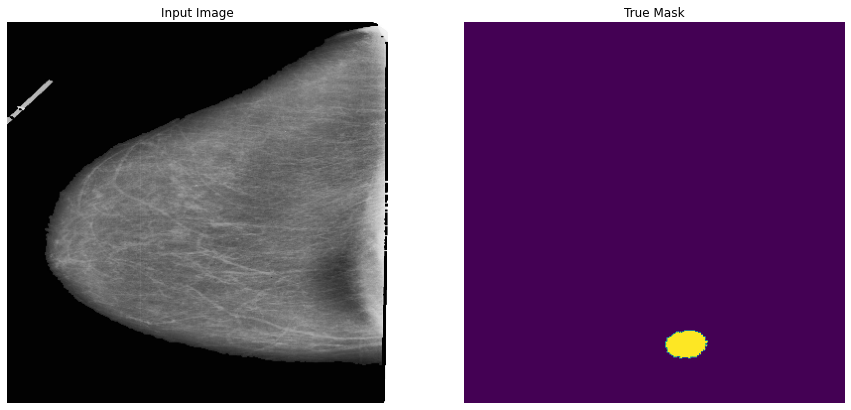

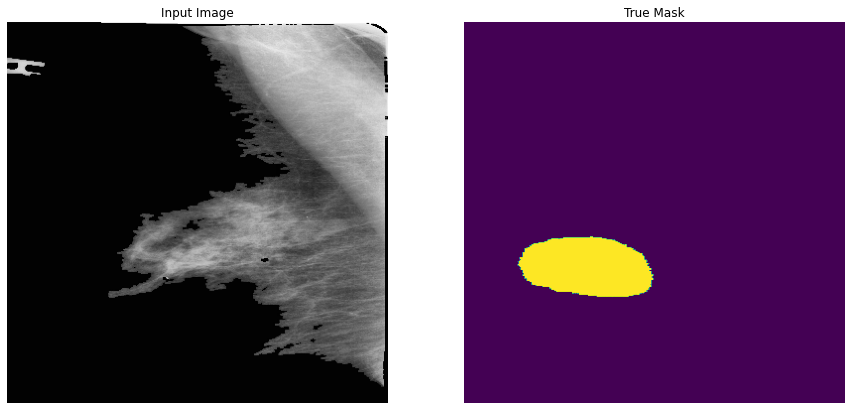

In [ ]:
for images, masks in train_batches.take(2):
  
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
def mean_iou(labels, logits, num_classes=1):
    with tf.name_scope('loss mine'):
        logits=tf.reshape(logits, [-1])
        trn_labels=tf.reshape(labels, [-1])
        inter=tf.reduce_sum(tf.multiply(logits,trn_labels))

        '''
        Eq. (2) The union part - element-wise sum and multiplication, then vector sum
        '''
        union=tf.reduce_sum(tf.subtract(tf.add(logits,trn_labels),tf.multiply(logits,trn_labels)))

        # Eq. (4)
        loss=tf.multiply(tf.constant(1.0, dtype=tf.float32),tf.divide(inter,union))
    return loss

In [ ]:
def loss_fn(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.MeanIoU(num_classes=3)])
# model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              # metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss=tf.losses.Giuo, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    print(model.predict(sample_image[tf.newaxis, ...]).shape)
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

(1, 384, 384, 1)


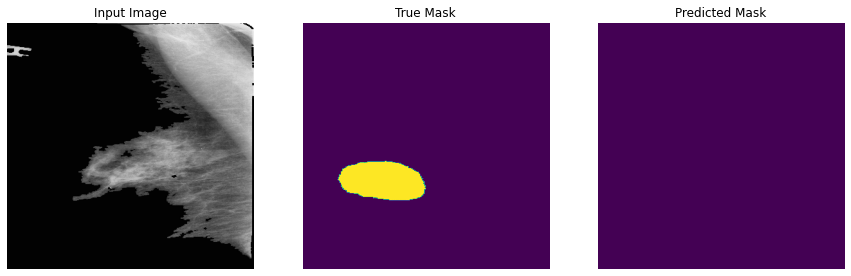

In [ ]:
show_predictions()

(1, 384, 384, 1)


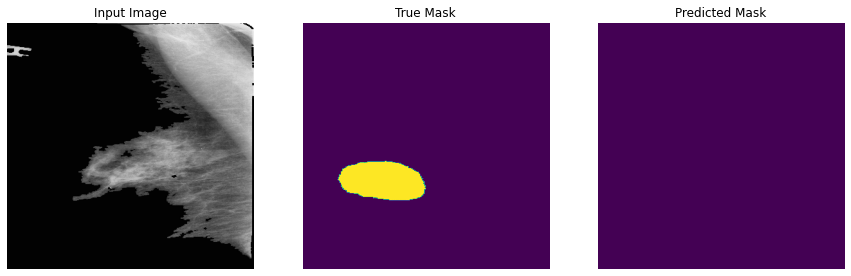

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
from IPython.display import clear_output

(1, 384, 384, 1)


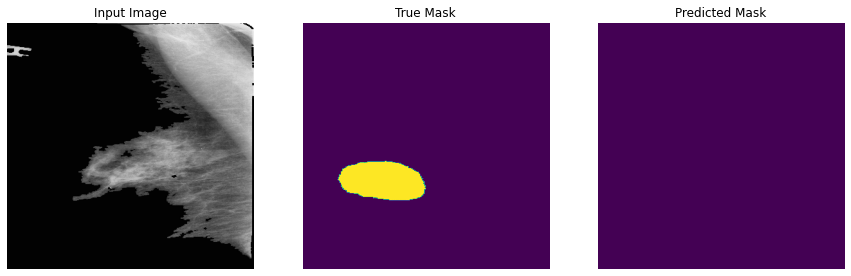


Sample Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(dfSCM2[-int(len(dfSCM2)*0.7):])//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
model.save_weights('/content/drive/MyDrive/Uempw')